# Import
---

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

from sklearn.preprocessing import StandardScaler

# Data
---

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [3]:
# Start by doing the WRONG thing - trying to predict the price itself
series = df['close'].values.reshape(-1, 1)

In [4]:
# Normalize data
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [5]:
# Make the dataset
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)  # now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print(X.shape, Y.shape)

(1249, 10, 1) (1249,)


# Model
---

Epoch 1/64
20/20 [==============================] - 1s 27ms/step - loss: 0.6977 - val_loss: 1.0851
Epoch 2/64
20/20 [==============================] - 0s 6ms/step - loss: 0.1246 - val_loss: 0.4613
Epoch 3/64
20/20 [==============================] - 0s 7ms/step - loss: 0.0570 - val_loss: 0.5975
Epoch 4/64
20/20 [==============================] - 0s 7ms/step - loss: 0.0310 - val_loss: 0.3018
Epoch 5/64
20/20 [==============================] - 0s 8ms/step - loss: 0.0175 - val_loss: 0.1930
Epoch 6/64
20/20 [==============================] - 0s 7ms/step - loss: 0.0119 - val_loss: 0.1293
Epoch 7/64
20/20 [==============================] - 0s 7ms/step - loss: 0.0099 - val_loss: 0.0979
Epoch 8/64
20/20 [==============================] - 0s 7ms/step - loss: 0.0089 - val_loss: 0.0769
Epoch 9/64
20/20 [==============================] - 0s 7ms/step - loss: 0.0082 - val_loss: 0.0688
Epoch 10/64
20/20 [==============================] - 0s 8ms/step - loss: 0.0080 - val_loss: 0.0768
Epoch 11/64
20/20 

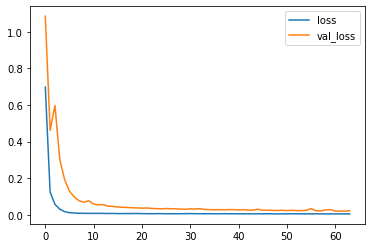

In [6]:
## AutoRegressive RNN
# Build
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)

# Compile
model.compile(
    loss='mse',
    optimizer=Adam(lr=0.01)
)

# Train
r = model.fit(X[:-N//2], Y[:-N//2],
              validation_data=(X[-N//2:], Y[-N//2:]),
              epochs=64, batch_size=32)

# Plot
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

# Predict
---

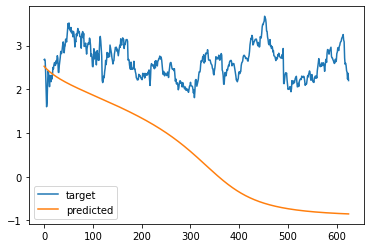

In [7]:
validation_test = Y[-N//2:]
validation_predict = []

last_x = X[-N//2]

while len(validation_predict) < len(validation_test):
  p = model.predict(last_x.reshape(-1, T, 1))[0, 0]

  validation_predict.append(p)

  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_test, label='target')
plt.plot(validation_predict, label='predicted')
plt.legend()

# Improvement
---

In [8]:
# calculate returns by first shifting data
df['PrevClose'] = df['close'].shift(1)  # move everything up 1

# so now its like
# close / prev close
# x[2] x[1]
# x[3] x[2]
# x[4] x[3]
# ...
# x[t] x[t-1]

In [9]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


In [10]:
# then the return is
# (x[t] - x[t-1]) / x[t-1]
df['Return'] = (df['close'] - df['PrevClose']) / df['PrevClose']

In [11]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose,Return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


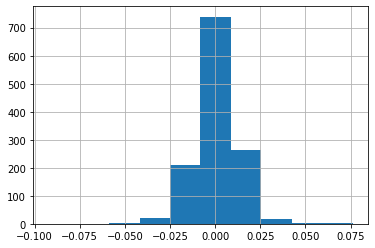

In [12]:
df['Return'].hist()

In [13]:
series = df['Return'].values[1:].reshape(-1, 1)

# normalize the data
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [14]:
# build the dataset
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)
N = len(X)
print(X.shape, Y.shape)

(1248, 10, 1) (1248,)


Epoch 1/80
20/20 [==============================] - 1s 26ms/step - loss: 0.9945 - val_loss: 1.1553
Epoch 2/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9921 - val_loss: 1.1439
Epoch 3/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9870 - val_loss: 1.1551
Epoch 4/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9845 - val_loss: 1.1451
Epoch 5/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9840 - val_loss: 1.1434
Epoch 6/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9830 - val_loss: 1.1420
Epoch 7/80
20/20 [==============================] - 0s 6ms/step - loss: 0.9843 - val_loss: 1.1462
Epoch 8/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9834 - val_loss: 1.1559
Epoch 9/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9845 - val_loss: 1.1448
Epoch 10/80
20/20 [==============================] - 0s 8ms/step - loss: 0.9821 - val_loss: 1.1660
Epoch 11/80
20/20 

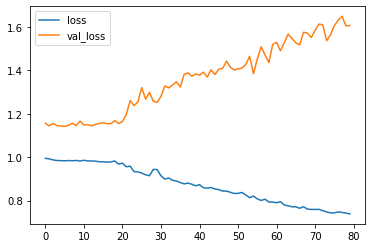

In [15]:
## AutoRegressive
# Build
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)

model.compile(
    loss='mse',
    optimizer=Adam(lr=0.01)
)

r = model.fit(X[:-N//2], Y[:-N//2],
              validation_data=(X[-N//2:], Y[-N//2:]),
              epochs=80, batch_size=32)

plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(1248, 1)


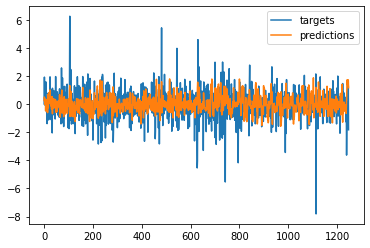

In [17]:
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()

In [ ]:
validation_test = Y[-N//2:]
validation_predict = []

last_x = X[-N//2]

while len(validation_predict) < len(validation_test):
  p = model.predict(last_x.reshape(-1, T, 1))[0, 0]

  validation_predict.append(p)

  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_test, label='target')
plt.plot(validation_predict, label='predicted')
plt.legend()